**Notebook 1** (v1)

Configuración y exploración inicial en Google Colab

Objetivo:
- Entender los datos

Acabado

**Librerías**

In [1]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

import requests
import os

**Instalación de PySpark**

El paquete "dataproc-spark-connect", preinstalado en Colab, requiere PySpark 3.5.1

In [2]:
# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

print(pyspark.__version__)

3.5.1


Instalación y configuración de Java (necesario para usar PySpark en Google Colab)

- openjdk-8-jdk-headless: versión de Java sin entorno gráfico
- qq > /dev/null: suprime la salida del proceso (modo silencioso)
- JAVA_HOME: variable de entorno para indicar a PySpark dónde puede encontrar Java

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

**Google Drive**

Montaje de Google Drive para almacenar ficheros, y creación de la estructura de directorios

In [4]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# crea estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
RAW_DIR = f"{PROJECT_ROOT}/raw"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"

# crea directorios si no existen
raw_dir = f"{PROJECT_ROOT}/raw"
bronze_dir = f"{PROJECT_ROOT}/bronze"

# crea directorios si no existen
for path in [RAW_DIR, BRONZE_DIR]:
    os.makedirs(path, exist_ok=True)

**Configuración de Spark**

- spark.driver.memory: asigna GB al proceso driver (coordinador de trabajo de Spark)
- spark.sql.adaptive.enabled: true, activa el Adaptative Query Execution (AQE),
ajuste dinámico del plan de ejecución en tiempo de ejecución
- spark.sql.adaptive.coalescePartitions.enabled: true, permite a AQE reducir el número
de particiones en tiempo de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)
- spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos
al driver desde los executors; evita que el driver se quede sin memoria

In [6]:
# configuración optimizada de Spark para Colab
spark = SparkSession.builder \
    .appName("NYC-Taxi-Prototipo") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


In [7]:
# verifica configuración de Spark
print("=== VERIFICANDO CONFIGURACIÓN DE SPARK ===")
conf = spark.sparkContext.getConf()

# configuraciones específicas
driver_memory = conf.get('spark.driver.memory', 'Default (1g)')
adaptive_enabled = conf.get('spark.sql.adaptive.enabled', 'Default (false)')
coalesce_enabled = conf.get('spark.sql.adaptive.coalescePartitions.enabled', 'Default (true)')
max_result_size = conf.get('spark.driver.maxResultSize', 'Default (1g)')

print(f"✓ Driver Memory: {driver_memory}")
print(f"✓ Adaptive Query Execution: {adaptive_enabled}")
print(f"✓ Adaptive Coalesce Partitions: {coalesce_enabled}")
print(f"✓ Max Result Size: {max_result_size}")

print(f"\nℹ️  Spark Version: {spark.version}")
print(f"ℹ️  Cores disponibles: {spark.sparkContext.defaultParallelism}")
print(f"ℹ️  Master: {spark.sparkContext.master}")

=== VERIFICANDO CONFIGURACIÓN DE SPARK ===
✓ Driver Memory: 4g
✓ Adaptive Query Execution: true
✓ Adaptive Coalesce Partitions: true
✓ Max Result Size: 2g

ℹ️  Spark Version: 3.5.1
ℹ️  Cores disponibles: 2
ℹ️  Master: local[*]


**Descarga de datos**

In [8]:
def download_nyc_taxi_data(year=2023, month=1, save_path="/content/drive/MyDrive/taxi_project/raw/"):
    """
    Descarga y guarda en disco los datos de un mes concreto de NYC Taxi desde la fuente oficial

    Args:
      year (int): año de los datos
      month (int): mes de los datos
      save_path (str): ruta donde guardar el archivo descargado

    Returns:
      str, ruta del archivo descargado o None en caso de error
    """
    # nombre del fichero a partir del año y mes proporcionados
    filename = f"yellow_tripdata_{year}-{month:02d}.parquet"
    # URL oficial del dataset
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{filename}"

    print(f"Descargando: {filename}")
    print(f"URL: {url}")

    try:
        # solicitud HTTP para descargar el archivo
        response = requests.get(url)
        # lanza una excepción si la respuesta contiene un error
        response.raise_for_status()

        # ruta del archivo donde guardar el contenido descargado
        if save_path.endswith('/'):
            file_path = f"{save_path}{filename}"
        else:
            file_path = f"{save_path}/{filename}"

        # guarda el contenido descargado en modo binario (sobreescribe si ya existe)
        with open(file_path, 'wb') as f:
            f.write(response.content)

        # calcula el tamaño del archivo en MB
        file_size = os.path.getsize(file_path) / (1024*1024)
        print(f"✅ Descarga completada: {file_size:.1f} MB")
        return file_path

    except requests.exceptions.RequestException as e:
        # captura errores relacionados con la descarga
        print(f"❌ Error en la descarga: {e}")
        return None

In [9]:
# descarga datos de enero 2023
file_path = download_nyc_taxi_data(2023, 1, save_path=raw_dir)

if file_path:
    print(f"Archivo guardado en: {file_path}")
else:
    print("Error: No se pudo descargar el archivo")

Descargando: yellow_tripdata_2023-01.parquet
URL: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
✅ Descarga completada: 45.5 MB
Archivo guardado en: /content/drive/MyDrive/taxi_project/raw/yellow_tripdata_2023-01.parquet


In [10]:
# carga datos en Dataframe de Spark
try:
    ds = spark.read.parquet(file_path)
    print("✅ Datos cargados exitosamente en Spark")
    print(f"Número de registros: {ds.count():,}")
    print(f"Número de columnas: {len(ds.columns)}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")

✅ Datos cargados exitosamente en Spark
Número de registros: 3,066,766
Número de columnas: 19


**Esquema de datos**

In [11]:
# esquema
print("=== ESQUEMA DE DATOS ===")
ds.printSchema()

=== ESQUEMA DE DATOS ===
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Columnas:

- VendorID: identificador del proveedor de taxi (CMT/VTS)
- tpep_pickup_datetime: fecha y hora del inicio del viaje
- tpep_dropoff_datetime: fecha y hora del fin del viaje
- passenger_count: número de pasajeros
- trip_distance: distancia recorrida en millas
- RatecodeID: código de tarifa usada (1 a 6)
- store_and_fwd_flag: datos almacenados temporalmente en el vehículo antes de enviarse (Y/N)
- PULocationID: ID de la zona de recogida
- DOLocationID: ID de la zona de destino
- payment_type: tipo de pago (1 a 6)
- fare_amount: importe base de la tarifa del viaje (sin extras)
- extra: cargos adicionales
- mta_tax: impuesto obligatorio
- tip_amount: propina
- tolls_amount: total en peajes
- improvement_surcharge: recargo por mejoras del servicio
- total_amount: total pagado por el cliente
- congestion_surcharge: recargo por congestión de tráfico
- airport_fee: tarifa para viajes desde/hacia los aeropuertos

**Esquema esperado de datos**

Para poder automatizar la validación del esquema de los datos y por control de calidad de los mismos vamos a definir el esquema esperado de validación. De esta forma, en el futuro siempre podremos confirmar que el archivo cargado se corresponde con este esquema.

In [12]:
# esquema esperado de datos
expected_schema = StructType([
    StructField("VendorID", LongType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", DoubleType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", DoubleType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", LongType(), True),
    StructField("DOLocationID", LongType(), True),
    StructField("payment_type", LongType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
    StructField("airport_fee", DoubleType(), True)
])

print("=== ESQUEMA ESPERADO DE DATOS ===")
for field in expected_schema.fields:
    print(f"{field.name}: {field.dataType}")

=== ESQUEMA ESPERADO DE DATOS ===
VendorID: LongType()
tpep_pickup_datetime: TimestampType()
tpep_dropoff_datetime: TimestampType()
passenger_count: DoubleType()
trip_distance: DoubleType()
RatecodeID: DoubleType()
store_and_fwd_flag: StringType()
PULocationID: LongType()
DOLocationID: LongType()
payment_type: LongType()
fare_amount: DoubleType()
extra: DoubleType()
mta_tax: DoubleType()
tip_amount: DoubleType()
tolls_amount: DoubleType()
improvement_surcharge: DoubleType()
total_amount: DoubleType()
congestion_surcharge: DoubleType()
airport_fee: DoubleType()


Una vez definido el esquema esperado de datos, podemos volver a cargar el archivo original usando dicho esquema, de forma que en el futuro evitaremos que Spark pueda inferir tipos incorrectos.

In [13]:
# carga datos en Dataframe de Spark
try:
    ds_validado = spark.read.schema(expected_schema).parquet(file_path)
    print("✅ Datos cargados exitosamente en Spark")
    print(f"Número de registros: {ds.count():,}")
    print(f"Número de columnas: {len(ds.columns)}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")

✅ Datos cargados exitosamente en Spark
Número de registros: 3,066,766
Número de columnas: 19


**Análisis de datos**

In [14]:
print("\n=== PRIMERAS 5 FILAS ===")
ds_validado.show(5, truncate=False)


=== PRIMERAS 5 FILAS ===
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|2       |2023-01-01 00:32:10 |2023-01-01 00:40:36  |1.0            |0.97         |1.0       |N                 |161         |141         |2           |9.3      

In [15]:
# estadísticas básicas
print("=== ESTADÍSTICAS BÁSICAS ===")
print(f"Total de registros: {ds_validado.count():,}")

=== ESTADÍSTICAS BÁSICAS ===
Total de registros: 3,066,766


In [16]:
## valores nulos

# inicializa lista de resultados
null_counts = []
# recorre las columnas
for col_name in ds_validado.columns:

    # cuenta valores nulos de la columna actual
    null_count = ds_validado.filter(col(col_name).isNull()).count()

    ## calcula el porcentaje de nulos como un float estándar de Python
    # número total de registros del Dataframe
    total_records = ds_validado.count()
    if total_records > 0:
        # hay registros
        null_percentage = (null_count / total_records) * 100
    else:
        # no hay registros: evita división por cero
        null_percentage = 0.0

    # diccionario nombre columna, número nulos y porcentaje nulos
    null_counts.append({
        'column': col_name,
        'null_count': null_count,
        # función round incorporada de Python
        'null_percentage': __builtins__.round(null_percentage, 2)
    })

# convierte la lista de resultados en Dataframe de Pandas
null_ds = pd.DataFrame(null_counts)

print("\n=== VALORES NULOS POR COLUMNA ===")
print(null_ds.to_string(index=False))


=== VALORES NULOS POR COLUMNA ===
               column  null_count  null_percentage
             VendorID           0             0.00
 tpep_pickup_datetime           0             0.00
tpep_dropoff_datetime           0             0.00
      passenger_count       71743             2.34
        trip_distance           0             0.00
           RatecodeID       71743             2.34
   store_and_fwd_flag       71743             2.34
         PULocationID           0             0.00
         DOLocationID           0             0.00
         payment_type           0             0.00
          fare_amount           0             0.00
                extra           0             0.00
              mta_tax           0             0.00
           tip_amount           0             0.00
         tolls_amount           0             0.00
improvement_surcharge           0             0.00
         total_amount           0             0.00
 congestion_surcharge       71743             2

In [17]:
# análisis de columnas numéricas clave
numeric_columns = ['trip_distance', 'fare_amount', 'total_amount', 'passenger_count']

print("=== ESTADÍSTICAS NUMÉRICAS ===")
ds_validado.select(numeric_columns).describe().show()

=== ESTADÍSTICAS NUMÉRICAS ===
+-------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|      total_amount|   passenger_count|
+-------+------------------+------------------+------------------+------------------+
|  count|           3066766|           3066766|           3066766|           2995023|
|   mean|3.8473420306601414| 18.36706861234247| 27.02038310708492|1.3625321074328978|
| stddev|249.58375606858166|17.807821939337924|22.163588952492184|0.8961199745510026|
|    min|               0.0|            -900.0|            -751.0|               0.0|
|    max|         258928.15|            1160.1|            1169.4|               9.0|
+-------+------------------+------------------+------------------+------------------+



In [18]:
# detección de valores anómalos
print("=== DETECCIÓN DE VALORES ANÓMALOS ===")

# viajes con distancia 0 o negativa
zero_distance = ds_validado.filter(col("trip_distance") <= 0).count()
print(f"Viajes con distancia <= 0: {zero_distance:,} ({zero_distance/ds_validado.count()*100:.2f}%)")

# tarifas negativas o 0
negative_fare = ds_validado.filter(col("fare_amount") <= 0).count()
print(f"Tarifas <= 0: {negative_fare:,} ({negative_fare/ds_validado.count()*100:.2f}%)")

# número de pasajeros anómalo
zero_passengers = ds_validado.filter(col("passenger_count") <= 0).count()
high_passengers = ds_validado.filter(col("passenger_count") > 6).count()
print(f"Sin pasajeros: {zero_passengers:,} ({zero_passengers/ds_validado.count()*100:.2f}%)")
print(f"Más de 6 pasajeros: {high_passengers:,} ({high_passengers/ds_validado.count()*100:.2f}%)")

=== DETECCIÓN DE VALORES ANÓMALOS ===
Viajes con distancia <= 0: 45,862 (1.50%)
Tarifas <= 0: 26,159 (0.85%)
Sin pasajeros: 51,164 (1.67%)
Más de 6 pasajeros: 20 (0.00%)


In [19]:
# análisis temporal
print("=== ANÁLISIS TEMPORAL ===")

# agrega columnas de fecha y hora
df_with_time = ds_validado.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                .withColumn("pickup_date", to_date("tpep_pickup_datetime")) \
                .withColumn("pickup_day_of_week", dayofweek("tpep_pickup_datetime"))

# viajes por hora del día
hourly_trips = df_with_time.groupBy("pickup_hour") \
                          .count() \
                          .orderBy("pickup_hour") \
                          .toPandas()

print("Distribución de viajes por hora:")
print(hourly_trips.to_string(index=False))

=== ANÁLISIS TEMPORAL ===
Distribución de viajes por hora:
 pickup_hour  count
           0  84969
           1  59799
           2  42040
           3  27438
           4  17835
           5  18011
           6  43860
           7  86877
           8 116865
           9 131111
          10 143666
          11 154157
          12 169858
          13 178739
          14 191604
          15 196424
          16 195977
          17 209493
          18 215889
          19 192801
          20 165862
          21 161548
          22 147415
          23 114528


In [20]:
# análisis geográfico
print("=== ANÁLISIS DE UBICACIONES ===")

# 10 zonas más habituales de recogida
top_pickup_zones = ds_validado.groupBy("PULocationID") \
                     .count() \
                     .orderBy(desc("count")) \
                     .limit(10)

print("10 zonas más habituales de recogida:")
top_pickup_zones.show()

# 10 zonas más habituales de destino
top_dropoff_zones = ds_validado.groupBy("DOLocationID") \
                      .count() \
                      .orderBy(desc("count")) \
                      .limit(10)

print("10 zonas más habituales de destino:")
top_dropoff_zones.show()

=== ANÁLISIS DE UBICACIONES ===
10 zonas más habituales de recogida:
+------------+------+
|PULocationID| count|
+------------+------+
|         132|160030|
|         237|148074|
|         236|138391|
|         161|135417|
|         186|109227|
|         162|105334|
|         142|100228|
|         230| 98991|
|         138| 89188|
|         170| 88346|
+------------+------+

10 zonas más habituales de destino:
+------------+------+
|DOLocationID| count|
+------------+------+
|         236|146348|
|         237|132364|
|         161|116149|
|         230| 89878|
|         170| 88783|
|         239| 87969|
|         142| 87969|
|         141| 87655|
|         162| 82739|
|          48| 77383|
+------------+------+



In [21]:
# resumen de calidad de datos
print("=== RESUMEN DE CALIDAD DE DATOS ===")

# número total de registros
total_records = ds_validado.count()

# diccionario con un resumen de métricas de calidad
quality_issues = {
    'Total de registros': total_records,
    'Registros con distancia <= 0': zero_distance,
    'Registros con tarifa <= 0': negative_fare,
    'Registros sin pasajeros': zero_passengers,
    'Registros válidos estimados': total_records - zero_distance - negative_fare - zero_passengers
}

# itera sobre cada entrada del resumen
for issue, count in quality_issues.items():
    if 'Total' in issue or 'válidos' in issue:
        # nombre del índice incluye Total o válidos: imprime el número
        print(f"{issue}: {count:,}")
    else:
        # en otro caso, imprime el porcentaje
        percentage = (count / total_records) * 100
        print(f"{issue}: {count:,} ({percentage:.2f}%)")

=== RESUMEN DE CALIDAD DE DATOS ===
Total de registros: 3,066,766
Registros con distancia <= 0: 45,862 (1.50%)
Registros con tarifa <= 0: 26,159 (0.85%)
Registros sin pasajeros: 51,164 (1.67%)
Registros válidos estimados: 2,943,581


**Visualización de datos**

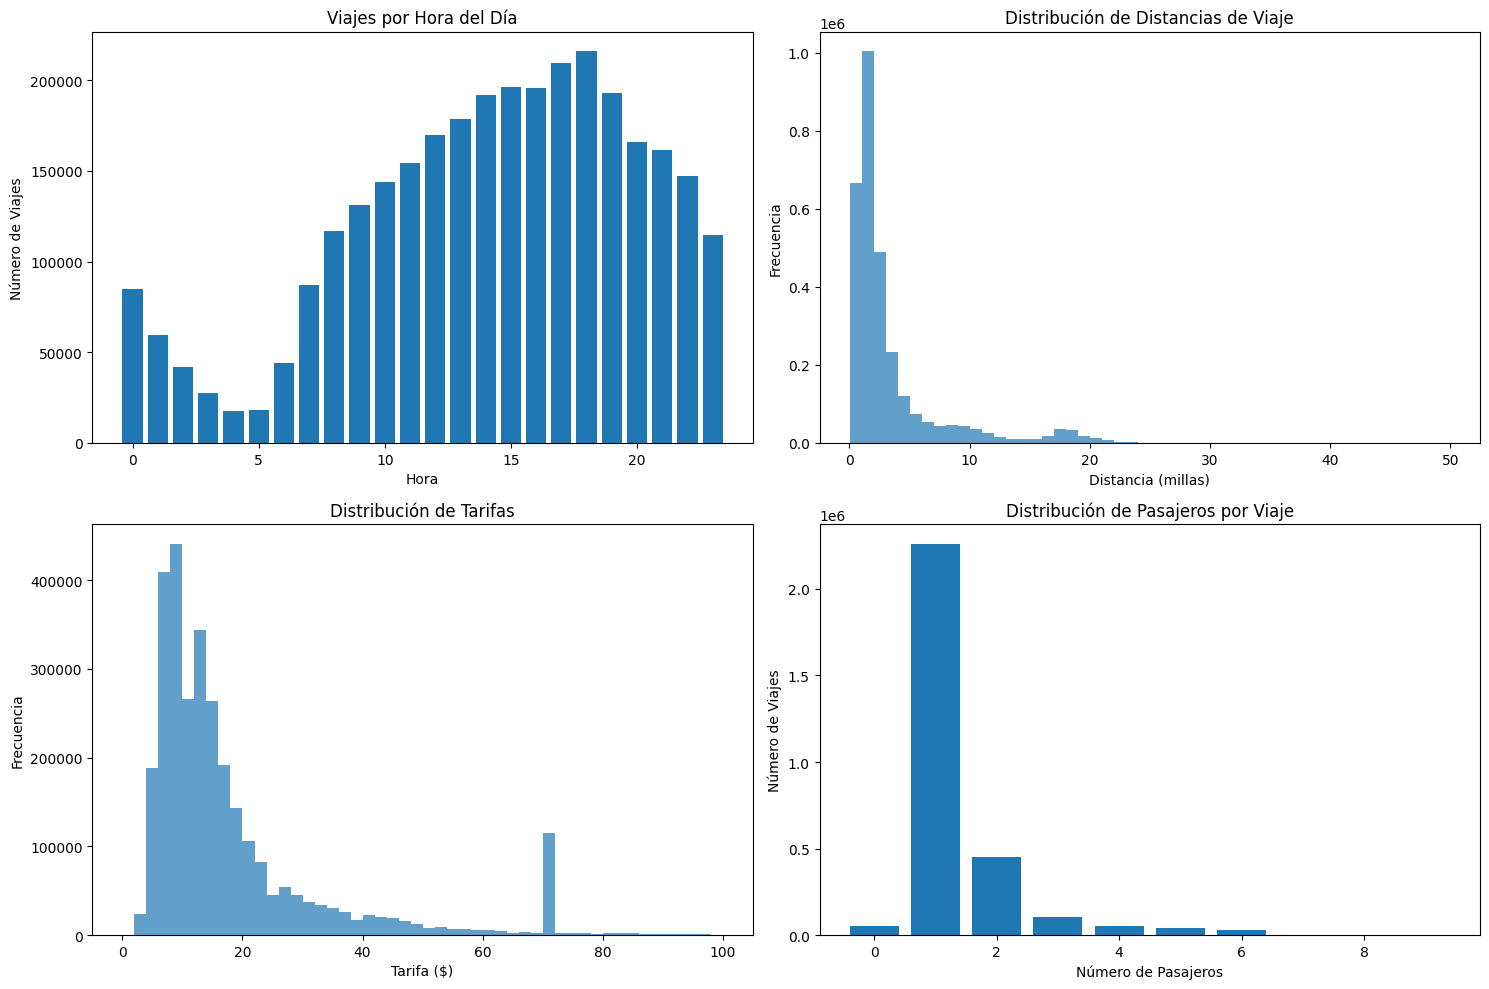

In [22]:
# visualizaciones básicas
plt.figure(figsize=(15, 10))

# viajes por hora
plt.subplot(2, 2, 1)
plt.bar(hourly_trips['pickup_hour'], hourly_trips['count'])
plt.title('Viajes por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Número de Viajes')

# distribución de distancias (filtrada)
distance_data = ds_validado.filter((col("trip_distance") > 0) & (col("trip_distance") < 50)) \
                  .select("trip_distance") \
                  .toPandas()

plt.subplot(2, 2, 2)
plt.hist(distance_data['trip_distance'], bins=50, alpha=0.7)
plt.title('Distribución de Distancias de Viaje')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')

# distribución de tarifas (filtrada)
fare_data = ds_validado.filter((col("fare_amount") > 0) & (col("fare_amount") < 100)) \
              .select("fare_amount") \
              .toPandas()

plt.subplot(2, 2, 3)
plt.hist(fare_data['fare_amount'], bins=50, alpha=0.7)
plt.title('Distribución de Tarifas')
plt.xlabel('Tarifa ($)')
plt.ylabel('Frecuencia')

# pasajeros por viaje
passenger_data = ds_validado.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

plt.subplot(2, 2, 4)
plt.bar(passenger_data['passenger_count'], passenger_data['count'])
plt.title('Distribución de Pasajeros por Viaje')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Número de Viajes')

plt.tight_layout()
plt.show()

**Guardar datos**

In [23]:
# guarda datos en Bronze Layer
print("=== GUARDANDO EN BRONZE LAYER ===")

# ruta del fichero a guardar
bronze_path = bronze_dir + "/taxi_jan_2023/"

try:
    # operación de escritura con formato parquet, borra datos existentes si los hay,
    # aplica compresión Snappy (rápida y eficiente)
    ds_validado.write \
      .mode("overwrite") \
      .option("compression", "snappy") \
      .parquet(bronze_path)

    print(f"✅ Datos guardados en Bronze Layer: {bronze_path}")

    # verifica que se haya guardado correctamente
    bronze_df = spark.read.parquet(bronze_path)
    print(f"Verificación: {bronze_df.count():,} registros en Bronze Layer")

except Exception as e:
    print(f"❌ Error al guardar en Bronze Layer: {e}")

=== GUARDANDO EN BRONZE LAYER ===
✅ Datos guardados en Bronze Layer: /content/drive/MyDrive/taxi_project/bronze/taxi_jan_2023/
Verificación: 3,066,766 registros en Bronze Layer


In [24]:
print("\n=== ARCHIVOS CREADOS ===")
print(f"- Raw data: {file_path}")
print(f"- Bronze Layer: {bronze_path}")


=== ARCHIVOS CREADOS ===
- Raw data: /content/drive/MyDrive/taxi_project/raw/yellow_tripdata_2023-01.parquet
- Bronze Layer: /content/drive/MyDrive/taxi_project/bronze/taxi_jan_2023/


In [25]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
